In [9]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import cv2
import torchsummary
from sklearn.metrics import recall_score
from glob import glob
import os


import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
tranf = tr.Compose([tr.Resize(16), tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='../datasets/emart24/beverage', transform=tranf)

In [3]:
len(trainset)

30560

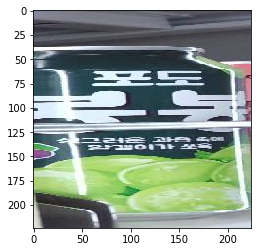

In [8]:
idx = np.random.randint(len(trainset))
img = cv2.imread(trainset.imgs[idx][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)  # mnist 같이 색 반전으로 보기

## create train dataset csv

In [10]:
img_dir = '../datasets/emart24/beverage'
result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]
num_to_class = dict(zip(range(len(label_list)), label_list))

for label in num_to_class:
    file_list = glob(os.path.join(img_dir,num_to_class[label],'*'))
    
    for file in file_list:
        result.append(['Train_{}'.format(idx), idx, label, num_to_class[label], file])
        idx += 1

In [11]:
num_to_class = dict(zip(range(len(label_list)), label_list))
num_to_class

{0: 'gal_bae_can',
 1: 'demisoda',
 2: 'peach',
 3: 'power',
 4: 'fanta_pine_pet',
 5: 'mango',
 6: 'milkis_pet',
 7: 'vita_500',
 8: 'apple_pet',
 9: 'mccol',
 10: 'fanta_orange_pet',
 11: 'dailyC',
 12: 'grape',
 13: 'sprite_pet',
 14: 'milkis_can',
 15: 'sprite_can',
 16: 'coca_can',
 17: 'sol',
 18: 'gas_hwal',
 19: 'aloe_pet',
 20: '2%_peach_pet',
 21: 'mogumogu',
 22: 'coca_pet',
 23: 'virak_pet',
 24: 'tejava',
 25: 'lemonade',
 26: 'hongsam',
 27: 'pocari',
 28: 'pepsi_can',
 29: 'pepsi_pet',
 30: 'gal_bae_pet',
 31: 'jeju_pet',
 32: '2%_can',
 33: 'red_bull',
 34: 'welchs',
 35: 'oranC'}

In [12]:
df_train = pd.DataFrame(result, columns=['image_id','idx','num_label','cate_label','image'])

In [13]:
df_train.head()

,image_id,idx,num_label,cate_label,image
0,Train_0,0,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2253.jpg
1,Train_1,1,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/450.jpg
2,Train_2,2,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2317.jpg
3,Train_3,3,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3972.jpg
4,Train_4,4,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4156.jpg


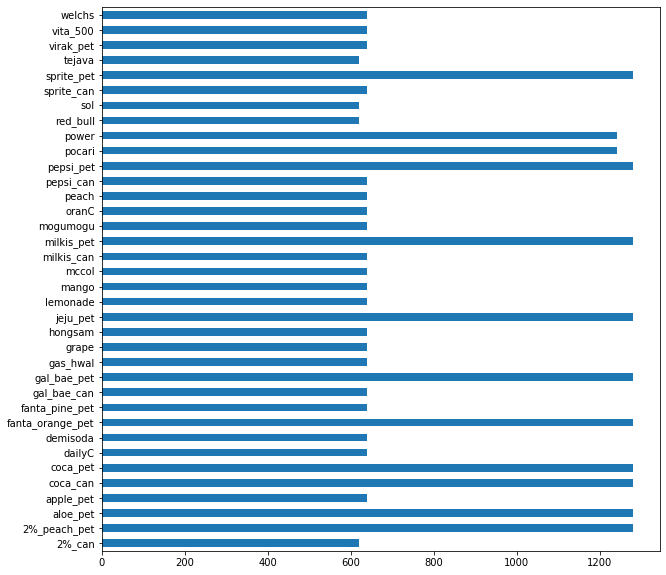

In [14]:
# 라벨이 불균형한 것을 볼 수 있다.
# 모델 학습이 잘 안될 수도 있어

plt.figure(figsize=(10,10))
df_train['cate_label'].value_counts().sort_index().plot.barh()

### Cross Validation
- 회사 데이터는 라벨이 1종류에서 분류하는 문제를 다루어야 함
- 따라서 multi 보다는 sklearn 의 StratifiedKFold 사용

In [33]:
df_train.head()

,image_id,idx,num_label,cate_label,image
0,Train_0,0,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2253.jpg
1,Train_1,1,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/450.jpg
2,Train_2,2,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2317.jpg
3,Train_3,3,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3972.jpg
4,Train_4,4,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4156.jpg


In [8]:
# data - id
X = df_train[['idx','num_label']].values[:,0]

# data - value
y = df_train[['idx','num_label']].values[:,1:]

In [9]:
df_train['fold'] = -1

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for i, (trn_idx, vld_idx) in enumerate(skf.split(X,y)):
    df_train.loc[vld_idx, 'fold'] = i

In [10]:
df_train['fold'].value_counts()

9    3056
8    3056
7    3056
6    3056
5    3056
4    3056
3    3056
2    3056
1    3056
0    3056
Name: fold, dtype: int64

In [11]:
df_train.head(20)

,image_id,idx,num_label,cate_label,image,fold
0,Train_0,0,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2253.jpg,8
1,Train_1,1,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/450.jpg,7
2,Train_2,2,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2317.jpg,8
3,Train_3,3,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3972.jpg,8
4,Train_4,4,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4156.jpg,1
5,Train_5,5,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3038.jpg,2
6,Train_6,6,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/1737.jpg,7
7,Train_7,7,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3520.jpg,6
8,Train_8,8,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3876.jpg,5
9,Train_9,9,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2549.jpg,0


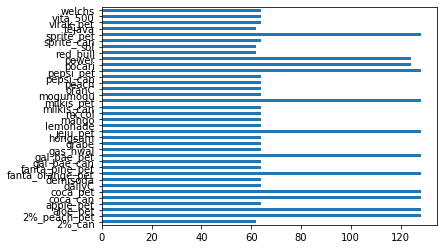

In [40]:
df_train[df_train['fold'] == 0]['cate_label'].value_counts().sort_index().plot.barh()

In [41]:
df_train.to_csv('train_fold.csv', index = False)

---

## Make pytorch dataset

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset

In [16]:
df_fold = pd.read_csv('./train_fold.csv')

In [17]:
index = 0
HEIGHT = 224 
WIDTH = 224

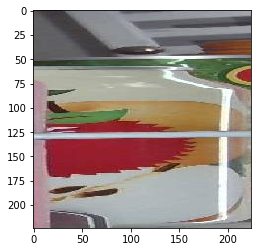

In [18]:
img = cv2.imread(df_fold['image'][index]).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [19]:
img.shape

(224, 224, 3)

In [17]:
# pytorch에 넣기 위해 채널 추가... 해야하는데 이미 3차원이라 안해도 됨
#img = img[:,:,np.newaxis]

In [20]:
label = df_train.iloc[index].num_label
label

0

---

## Dataset

## Train / Val split

In [21]:
trn_fold = [i for i in range(10) if i not in [4]]
vld_fold = [4]


In [22]:
trn_idx = df_fold.loc[df_fold['fold'].isin(trn_fold)].index
vld_idx = df_fold.loc[df_fold['fold'].isin(vld_fold)].index

In [23]:
vld_idx.shape

(3056,)

In [191]:
df_fold.loc[vld_idx]

,image_id,idx,num_label,cate_label,image,fold
33,Train_33,33,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4651.jpg,4
44,Train_44,44,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/354.jpg,4
47,Train_47,47,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3656.jpg,4
48,Train_48,48,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3824.jpg,4
53,Train_53,53,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4931.jpg,4
...,...,...,...,...,...,...
30483,Train_30483,30483,35,oranC,../datasets/emart24/beverage/oranC/2697.jpg,4
30500,Train_30500,30500,35,oranC,../datasets/emart24/beverage/oranC/1626.jpg,4
30507,Train_30507,30507,35,oranC,../datasets/emart24/beverage/oranC/3349.jpg,4
30525,Train_30525,30525,35,oranC,../datasets/emart24/beverage/oranC/3565.jpg,4


---

In [24]:
import pretrainedmodels

In [24]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [25]:
model_name = 'resnet50'
backbone = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

In [26]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
import torch.nn as nn

In [28]:
len(label_list)

36

In [29]:
in_features = backbone.last_linear.in_features
in_features

2048

In [30]:
backbone.last_linear = nn.Linear(in_features, len(label_list))
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
# batch  만들어서 확인
batchs = torch.rand(6,3,224,224)
batchs.shape

torch.Size([6, 3, 224, 224])

In [32]:
outputs = backbone(batchs)
outputs.shape

torch.Size([6, 36])

In [33]:
outputs.min()

tensor(-0.8119, grad_fn=<MinBackward1>)

---

## albumentation

In [34]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomGamma, VerticalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, 
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomContrast, RandomBrightness, RandomCrop, Resize, OpticalDistortion
)

from albumentations.pytorch import ToTensor

In [6]:
img = cv2.imread('./43.jpg')
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
#img = img.reshape((224,224))
img.shape

(224, 224, 3)

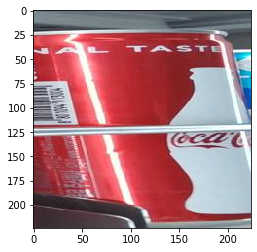

In [7]:
plt.imshow(img)

In [42]:
train_transforms = Compose([
        #Rotate(limit=30, p=0.5),
        #Rotate(limit=180, p=0.5),
        #RandomRotate90(p=1.0)
        #Transpose(p=1.0)
        Resize(248,248, p=0.5),     # resize 후 크롭
        RandomCrop(224,224, p=0.5),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.5,2)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.2,0.4)),
        RandomGamma(p=1, gamma_limit=(80,200)),
        ], p=0.6),
            
        OneOf([
            Rotate(limit=30, p=0.5),
            RandomRotate90(p=0.5),
            VerticalFlip(p=0.5)
        ], p=0.3),
    
        MotionBlur(p=0.2),   # 움직일때 흔들리는 것 같은 이미지
        ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(224,224, p=1),
        ToTensor()
        ],
        p=0.4)

valid_transforms = Compose([ ToTensor()])

Text(0.5, 1.0, 'transformed - torch.Size([3, 224, 224])')

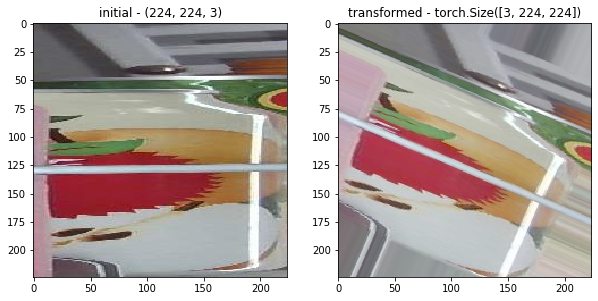

In [43]:
img1 = train_transforms(image=img)['image']

f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img1.permute(1,2,0))

ax[0].set_title('initial - {}'.format(img.shape))
ax[1].set_title('transformed - {}'.format(img1.shape))

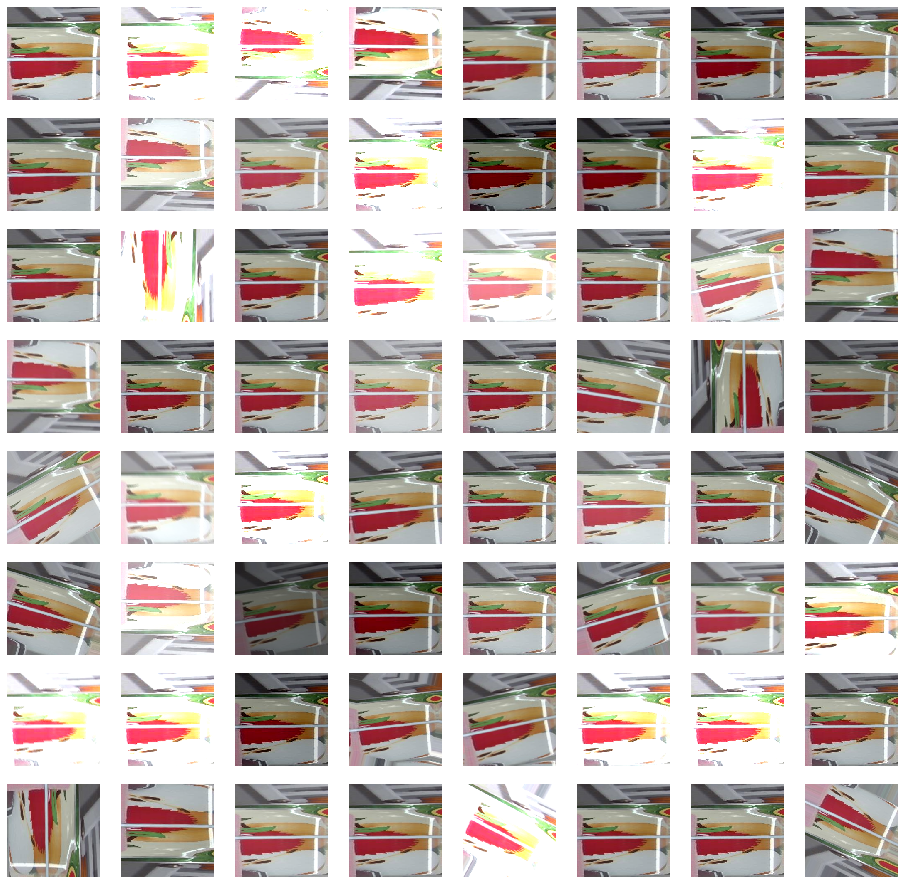

In [79]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
    axes[i//8, i%8].imshow(train_transforms(image=img)['image'].permute(1,2,0))
    axes[i//8, i%8].axis('off')

### DataSet 변경

In [95]:
class Em24Dataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        #self.img_ids = csv['image_id'].values
        self.img_ids = csv['idx'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = cv2.imread(df_fold['image'][index]).astype(np.uint8)
        #img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = np.repeat(img, 3, 2)
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        label = self.csv.iloc[index].num_label
        
        return (img, label)


In [94]:
df_fold

,image_id,idx,num_label,cate_label,image,fold
0,Train_0,0,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2253.jpg,8
1,Train_1,1,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/450.jpg,7
2,Train_2,2,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/2317.jpg,8
3,Train_3,3,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/3972.jpg,8
4,Train_4,4,0,gal_bae_can,../datasets/emart24/beverage/gal_bae_can/4156.jpg,1
...,...,...,...,...,...,...
30555,Train_30555,30555,35,oranC,../datasets/emart24/beverage/oranC/723.jpg,9
30556,Train_30556,30556,35,oranC,../datasets/emart24/beverage/oranC/263.jpg,3
30557,Train_30557,30557,35,oranC,../datasets/emart24/beverage/oranC/1914.jpg,1
30558,Train_30558,30558,35,oranC,../datasets/emart24/beverage/oranC/4476.jpg,0


In [37]:
index = 0
HEIGHT = 224
WIDTH = 224

df_fold = pd.read_csv('./train_fold.csv')
#df_train['fold'] = pd.read_csv('./input/df_folds.csv')['fold']
trn_fold = [i for i in range(5) if i not in [4]]
vld_fold = [4]

trn_idx = df_fold.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_fold.loc[df_train['fold'].isin(vld_fold)].index

KeyError: 'fold'

---

## Training

### 1. Create Dataloader

In [96]:
trn_dataset = Em24Dataset(csv = df_fold.loc[trn_idx], img_height = HEIGHT, img_width=WIDTH, transform=train_transforms)
vld_dataset = Em24Dataset(csv = df_fold.loc[vld_idx], img_height = HEIGHT, img_width=WIDTH, transform=valid_transforms)

#trn_dataset = Em24Dataset(csv = df_train.loc[trn_idx], img_height = HEIGHT, img_width=WIDTH, transform=None)
#vld_dataset = Em24Dataset(csv = df_train.loc[vld_idx], img_height = HEIGHT, img_width=WIDTH, transform=None)

In [97]:
trn_loader = DataLoader(trn_dataset,
                       shuffle=True,
                       num_workers=0,
                       batch_size=84)

vld_loader = DataLoader(vld_dataset,
                       shuffle=True,
                       num_workers=0,
                       batch_size=84)

---

### 2. Make Model, optimizer, criterion

In [47]:
torch.cuda.is_available()

True

In [48]:
model = backbone.cuda()

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [214]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Cross Entropy
- y : 실제값 (0 or 1) / y-hat : 예측값 (확률)
- 낮은 확률로 예측해서 맞추거나, 높은 확률로 예측해서 틀리는 경우 loss가 더 크다.

범주형 변수를 예측할 때 사용
- binary_crossentropy : 카테고리가 2개인 경우
- categorical_crossentropy : 3개 이상의 경우

In [50]:
# ReduceOnPlateau 는 현재 metric 을 지켜보면서 특정 epoch(patience) 에도 좋아지지 않으면, 
# 정해놓은 factor 만큼 감소. (lr = factor * lr)
loss_fn = nn.CrossEntropyLoss()
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='max',
                                                     verbose=True,
                                                     patience=7,
                                                     factor=0.5)

### 3. Training

In [781]:
train_loss = []
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [782]:
for inputs, targets in trn_loader:
    break

RuntimeError: DataLoader worker (pid(s) 7049) exited unexpectedly

In [784]:
inputs = inputs.cuda()
targets = targets.cuda()

In [788]:
logits = model(inputs)

RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 10.76 GiB total capacity; 8.05 GiB already allocated; 134.19 MiB free; 8.34 GiB reserved in total by PyTorch)

In [686]:
result = logits

In [687]:
loss = loss_fn(result, targets)

AttributeError: 'tuple' object has no attribute 'size'

In [98]:
best_score = -1
EPOCH = 1
#model = torch.nn.DataParallel(model, device_ids=[1,2]).cuda()

for epoch in range(EPOCH):
    train_loss = []
    model.train()
    
    for inputs, targets in tqdm_notebook(trn_loader):
        
        inputs = inputs.cuda()
        targets = targets.cuda()
        
        result = model(inputs)
        
        loss = loss_fn(result, targets)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        
    val_loss = []
    val_true = []
    val_pred = []
    
    model.eval()
    
    with torch.no_grad():
        
        for vld_inputs, vld_targets in tqdm_notebook(vld_loader):
            
            vld_inputs = vld_inputs.cuda()
            vld_targets = vld_targets.cuda()
            
            result = model(vld_inputs)
            
            val_loss.append(loss.item())
            
            result = result.cpu().argmax(dim=1).data.numpy()
            
            val_true.append(vld_targets.cpu().numpy())
            #val_pred.append(np.stack([result], axis=1))
            val_pred.append(result)
            
    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)
    
    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)
    
    score = recall_score(val_true, val_pred, average='macro')
    

    print(f'EPOCH:{epoch}, train_loss: {train_loss:.5f}, val_loss:{val_loss:.5f}, recall:{score:.5f}')

    if score > best_score:
        best_score = score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, 'model.pt')
    
    


EPOCH:0, train_loss: 0.64337, val_loss:0.59438, recall:0.02778


In [90]:

a = [i for i,j in zip(val_true, val_pred.reshape(-1)) if i == j ]
print(len(a) / len(val_true))

0.020942408376963352


In [114]:
val_pred[-32:]

array([0, 1, 1, 3, 0, 2, 0, 0, 2, 2, 0, 3, 2, 0, 0, 1, 0, 0, 3, 0, 3, 3,
       0, 3, 3, 1, 3, 2, 2, 0, 2, 1])

In [115]:
val_true[-32:]

array([ 6, 13, 10, 27,  0, 16,  2,  1, 20, 20,  5, 24, 16,  0,  6, 14,  1,
        3, 24,  3, 35, 22,  3, 31, 31, 10, 34, 16, 18,  5, 21,  8])

In [101]:
recall_score(val_true[0:5], val_pred[0:5], average='macro')

0.0

In [91]:
model(vld_inputs[0:5])[0]

tensor([-6.3211, -4.3089, -2.9188,  6.5150,  5.3582, -3.3429, -5.4115, -5.2490,
        -6.3107, -5.8261, -6.6759, -6.1592, -5.7378, -4.9333, -5.2923, -6.2575,
        -4.2891, -5.3684, -5.3000, -4.6284, -4.9247, -8.1527, -6.0023, -8.2775,
        -7.5788, -7.5543, -7.5146, -6.7849, -7.1159, -3.1061, -2.1372, -2.8159,
        -5.4437, -8.8959, -6.6713, -8.0321], device='cuda:0',
       grad_fn=<SelectBackward>)

In [119]:
dap = model(vld_inputs).cpu().argmax(dim=1)

In [124]:
[num_to_class[i] for i in dap.numpy()]

['gal_bae_can',
 'demisoda',
 'demisoda',
 'power',
 'gal_bae_can',
 'peach',
 'gal_bae_can',
 'gal_bae_can',
 'peach',
 'peach',
 'gal_bae_can',
 'power',
 'peach',
 'gal_bae_can',
 'gal_bae_can',
 'demisoda',
 'gal_bae_can',
 'gal_bae_can',
 'power',
 'gal_bae_can',
 'power',
 'power',
 'gal_bae_can',
 'power',
 'power',
 'demisoda',
 'power',
 'peach',
 'peach',
 'gal_bae_can',
 'peach',
 'demisoda']

In [103]:
vld_targets

tensor([ 6, 13, 10, 27,  0, 16,  2,  1, 20, 20,  5, 24, 16,  0,  6, 14,  1,  3,
        24,  3, 35, 22,  3, 31, 31, 10, 34, 16, 18,  5, 21,  8],
       device='cuda:0')

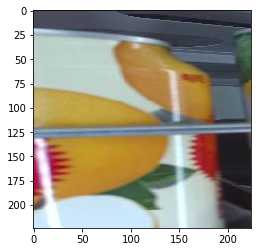

In [170]:
plt.imshow(vld_inputs.cpu()[0].permute(1,2,0).data.numpy())

In [171]:
num_to_class

{0: 'gal_bae_can',
 1: 'demisoda',
 2: 'peach',
 3: 'power',
 4: 'fanta_pine_pet',
 5: 'mango',
 6: 'milkis_pet',
 7: 'vita_500',
 8: 'apple_pet',
 9: 'mccol',
 10: 'fanta_orange_pet',
 11: 'dailyC',
 12: 'grape',
 13: 'sprite_pet',
 14: 'milkis_can',
 15: 'sprite_can',
 16: 'coca_can',
 17: 'sol',
 18: 'gas_hwal',
 19: 'aloe_pet',
 20: '2%_peach_pet',
 21: 'mogumogu',
 22: 'coca_pet',
 23: 'virak_pet',
 24: 'tejava',
 25: 'lemonade',
 26: 'hongsam',
 27: 'pocari',
 28: 'pepsi_can',
 29: 'pepsi_pet',
 30: 'gal_bae_pet',
 31: 'jeju_pet',
 32: '2%_can',
 33: 'red_bull',
 34: 'welchs',
 35: 'oranC'}

In [138]:
tt = []
for i in vld_loader:
    tt.append(i)
    print('*************************************')

*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
*************************************
************

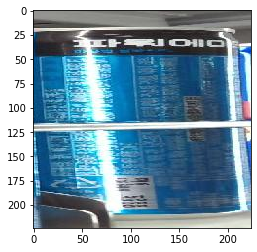

In [145]:
plt.imshow(tt[-1][0][2].permute(1,2,0))

In [146]:
tt[-1][1][2]

tensor(35)

In [141]:
tt[-1][0][0].shape

torch.Size([3, 224, 224])

In [142]:
tt[-1][1]

tensor([14,  2, 35, 30, 30, 30, 18, 29, 26, 35, 21, 32, 30, 16, 10, 15, 24,  1,
        16, 31, 22, 29, 35,  0,  3,  6, 17, 29,  5,  2, 22,  7])

In [165]:
a = model(vld_inputs)

In [169]:
torch.max(a.data, 1)[1]

tensor([0, 1, 1, 3, 0, 2, 0, 0, 2, 2, 0, 3, 2, 0, 0, 1, 0, 0, 3, 0, 3, 3, 0, 3,
        3, 1, 3, 2, 2, 0, 2, 1], device='cuda:0')

In [177]:
torch.max(a,1)

torch.return_types.max(
values=tensor([ 8.0448,  8.2715,  6.7854,  7.6894,  7.7387,  5.7184,  9.4655, 10.5856,
         5.2794,  5.0000,  9.0567,  6.2958,  5.2305,  9.1575, 10.2154,  8.5712,
         7.7440,  7.5576,  6.2291, 10.9173,  7.1998,  6.9936,  8.5243,  7.3359,
         6.0201,  7.9404,  6.7177,  5.3980,  5.2352,  7.9178,  5.1851,  7.7536],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0, 1, 1, 3, 0, 2, 0, 0, 2, 2, 0, 3, 2, 0, 0, 1, 0, 0, 3, 0, 3, 3, 0, 3,
        3, 1, 3, 2, 2, 0, 2, 1], device='cuda:0'))